In [ ]:
# Make sure you have GPU running
!nvidia-smi

Mon Jun 13 08:41:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Install and imports

In [ ]:
# install latest Haystack
!pip install --upgrade pip
!pip install git+https://github.com/deepset-ai/haystack.git#egg=farm-haystack[colab]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 19.7 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/deepset-ai/haystack.git to /tmp/pip-install-qafnpgkp/farm-haystack_22165ced5fd849e682efca58ddc41981
  Running command git clone --filter=blob:none --quiet https://github.com/deepset-ai/haystack.git /tmp/pip-install-qafnpgkp/farm-haystack_22165ced5fd849e682efca58ddc41981
  Resolved https://github.com/deepset-ai/haystack.git to commit 2a7e333d9a5d74c4fcdadeed372dd926734b2402
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.

## Imports

In [ ]:
#needed for filetype classifier
!apt-get install libmagic-dev
!pip install python-magic

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libmagic-mgc libmagic1
Suggested packages:
  file
The following NEW packages will be installed:
  libmagic-dev libmagic-mgc libmagic1
0 upgraded, 3 newly installed, 0 to remove and 62 not upgraded.
Need to get 332 kB of archives.
After this operation, 5,552 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libmagic-mgc amd64 1:5.32-2ubuntu0.4 [184 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libmagic1 amd64 1:5.32-2ubuntu0.4 [68.6 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libmagic-dev amd64 1:5.32-2ubuntu0.4 [79.7 kB]
Fetched 332 kB in 2s (174 kB/s)
Selecting previously unselected package libmagic-m

In [ ]:
from haystack.utils import convert_files_to_docs, launch_es, print_answers
from haystack.document_stores import ElasticsearchDocumentStore, FAISSDocumentStore
from haystack.schema import EvaluationResult, MultiLabel
from haystack.nodes import BM25Retriever, TfidfRetriever, EmbeddingRetriever, DensePassageRetriever, FARMReader, PreProcessor, JoinDocuments
from haystack.pipelines import ExtractiveQAPipeline, Pipeline

import os
from subprocess import Popen, PIPE, STDOUT

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
from datetime import date
import json


# Evaluation Extractive QA


## ElasticSearch

In [ ]:
# Start Elasticsearch from source in Colab / No Docker environments: 
! wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.9.2-linux-x86_64.tar.gz -q
! tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz
! chown -R daemon:daemon elasticsearch-7.9.2


In [ ]:
! chown -R daemon:daemon elasticsearch-7.9.2

es_server = Popen(
    ["elasticsearch-7.9.2/bin/elasticsearch"], stdout=PIPE, stderr=STDOUT, preexec_fn=lambda: os.setuid(1)  # as daemon
)
# wait until ES has started
! sleep 30

## Load Eval Data

In [ ]:
# this is a manually annotated dataset for german QA 
eval_filename = "/content/factoid-questions.json"

In [ ]:
#@title Select which type of questions the eval_filename (attribute in cell above) contains. { run: "auto" }

dataset_type = 'Factoid-Questions' #@param ["Factoid-Questions", "Yes-Questions", "No-Questions"]
#the dataset_type is later used as a title in the visualisation plot

In [ ]:
# make sure these indices do not collide with existing ones, the indices will be wiped clean before data is inserted
doc_index = "tutorial5_docs"
label_index = "tutorial5_labels"

# Connect to Elasticsearch
document_store = ElasticsearchDocumentStore(
    analyzer="german",
    host="localhost",
    username="",
    password="",
    index=doc_index,
    label_index=label_index,
    embedding_field="emb",
    embedding_dim=768,
    excluded_meta_data=["emb"],
)

# Delete documents and indices in case elastic search is reused (for instance after evaluating factoid questions reuse it for yes-questions)
document_store.delete_documents()
document_store.delete_documents(index=doc_index)
document_store.delete_documents(index=label_index)
print(f"before adding eval data: {document_store.get_document_count()}")

# Add evaluation data to Elasticsearch Document Store
# We first delete the custom tutorial indices to not have duplicate elements
# and also split our documents into shorter passages using the PreProcessor
preprocessor = PreProcessor(
    split_length=200,
    split_overlap=0,
    split_respect_sentence_boundary=False,
    clean_empty_lines=False,
    clean_whitespace=False,
)

# The add_eval_data() method converts the given dataset in json format into Haystack document and label objects. 
# Those objects are then indexed in their respective document and label index in the document store. 
# The method can be used with any dataset in SQuAD format.
document_store.add_eval_data(
    filename=eval_filename,
    doc_index=doc_index,
    label_index=label_index,
    preprocessor=preprocessor,
)

print(f"after adding eval data: {document_store.get_document_count()}")

INFO - haystack.telemetry -  Haystack sends anonymous usage data to understand the actual usage and steer dev efforts towards features that are most meaningful to users. You can opt-out at anytime by calling disable_telemetry() or by manually setting the environment variable HAYSTACK_TELEMETRY_ENABLED as described for different operating systems on the documentation page. More information at https://haystack.deepset.ai/guides/telemetry


before adding eval data: 0


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
WARNING - haystack.document_stores.utils -  No title information found for documents in QA file: /content/answers.json


after adding eval data: 82


## Pipeline

In [ ]:
# Initialize Retrievers
retriever_BM25 = BM25Retriever(document_store=document_store)
retriever_TFIDF = TfidfRetriever(document_store=document_store)
retriever_DPR = DensePassageRetriever(
  document_store=document_store,
  query_embedding_model="deepset/gbert-base-germandpr-question_encoder",
  passage_embedding_model="deepset/gbert-base-germandpr-ctx_encoder"
)

# Initialize Readers
# load reader provided by deepset 
reader_DEFAULT = FARMReader("deepset/roberta-base-squad2", top_k=5, return_no_answer=True, use_gpu=True)
reader_GQuad = FARMReader("deepset/gelectra-base-germanquad", top_k=5, return_no_answer=True, use_gpu=True)
reader_GQuad_large = FARMReader("deepset/gelectra-large-germanquad", top_k=5, return_no_answer=True, use_gpu=True)
reader_GQuad_distilled = FARMReader("deepset/gelectra-base-germanquad-distilled", top_k=5, return_no_answer=True, use_gpu=True)
reader_GBert = FARMReader("bert-base-german-cased", top_k=5, return_no_answer=True, use_gpu=True)

# load reader provided by deutsche telekom 
reader_telekom_electra_base = FARMReader("deutsche-telekom/electra-base-de-squad2", top_k=5, return_no_answer=True, use_gpu=True)
reader_telekom_multibert = FARMReader("deutsche-telekom/bert-multi-english-german-squad2", top_k=5, return_no_answer=True, use_gpu=True)

INFO - haystack.nodes.retriever.sparse -  Found 429 candidate paragraphs from 82 docs in DB
INFO - haystack.modeling.utils -  Using devices: CUDA:0
INFO - haystack.modeling.utils -  Number of GPUs: 1


Downloading:   0%|          | 0.00/327 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/234k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/718 [00:00<?, ?B/s]

INFO - haystack.modeling.model.language_model -  LOADING MODEL
INFO - haystack.modeling.model.language_model -  =============
INFO - haystack.modeling.model.language_model -  Could not find deepset/gbert-base-germandpr-question_encoder locally.
INFO - haystack.modeling.model.language_model -  Looking on Transformers Model Hub (in local cache and online)...


Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

INFO - haystack.modeling.model.language_model -  Automatically detected language from language model name: german
INFO - haystack.modeling.model.language_model -  Loaded deepset/gbert-base-germandpr-question_encoder


Downloading:   0%|          | 0.00/327 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/234k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/716 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizerFast'.
INFO - haystack.modeling.model.language_model -  LOADING MODEL
INFO - haystack.modeling.model.language_model -  =============
INFO - haystack.modeling.model.language_model -  Could not find deepset/gbert-base-germandpr-ctx_encoder locally.
INFO - haystack.modeling.model.language_model -  Looking on Transformers Model Hub (in local cache and online)...


Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

INFO - haystack.modeling.model.language_model -  Automatically detected language from language model name: german
INFO - haystack.modeling.model.language_model -  Loaded deepset/gbert-base-germandpr-ctx_encoder
INFO - haystack.modeling.utils -  Using devices: CUDA:0
INFO - haystack.modeling.utils -  Number of GPUs: 1
INFO - haystack.modeling.model.language_model -  LOADING MODEL
INFO - haystack.modeling.model.language_model -  =============
INFO - haystack.modeling.model.language_model -  Could not find deepset/roberta-base-squad2 locally.
INFO - haystack.modeling.model.language_model -  Looking on Transformers Model Hub (in local cache and online)...


Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/473M [00:00<?, ?B/s]

INFO - haystack.modeling.model.language_model -  Loaded deepset/roberta-base-squad2


Downloading:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

INFO - haystack.modeling.utils -  Using devices: CUDA
INFO - haystack.modeling.utils -  Number of GPUs: 1
INFO - haystack.modeling.infer -  Got ya 2 parallel workers to do inference ...
INFO - haystack.modeling.infer -   0     0  
INFO - haystack.modeling.infer -  /w\   /w\ 
INFO - haystack.modeling.infer -  /'\   / \ 
INFO - haystack.modeling.utils -  Using devices: CUDA:0
INFO - haystack.modeling.utils -  Number of GPUs: 1
INFO - haystack.modeling.model.language_model -  LOADING MODEL
INFO - haystack.modeling.model.language_model -  =============
INFO - haystack.modeling.model.language_model -  Could not find deepset/gelectra-base-germanquad locally.
INFO - haystack.modeling.model.language_model -  Looking on Transformers Model Hub (in local cache and online)...


Downloading:   0%|          | 0.00/740 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/417M [00:00<?, ?B/s]

INFO - haystack.modeling.model.language_model -  Automatically detected language from language model name: german
INFO - haystack.modeling.model.language_model -  Loaded deepset/gelectra-base-germanquad


Downloading:   0%|          | 0.00/358 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/234k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

INFO - haystack.modeling.utils -  Using devices: CUDA
INFO - haystack.modeling.utils -  Number of GPUs: 1
INFO - haystack.modeling.infer -  Got ya 2 parallel workers to do inference ...
INFO - haystack.modeling.infer -   0     0  
INFO - haystack.modeling.infer -  /w\   /w\ 
INFO - haystack.modeling.infer -  /'\   / \ 
INFO - haystack.modeling.utils -  Using devices: CUDA:0
INFO - haystack.modeling.utils -  Number of GPUs: 1
INFO - haystack.modeling.model.language_model -  LOADING MODEL
INFO - haystack.modeling.model.language_model -  =============
INFO - haystack.modeling.model.language_model -  Could not find deepset/gelectra-large-germanquad locally.
INFO - haystack.modeling.model.language_model -  Looking on Transformers Model Hub (in local cache and online)...


Downloading:   0%|          | 0.00/743 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

INFO - haystack.modeling.model.language_model -  Automatically detected language from language model name: german
INFO - haystack.modeling.model.language_model -  Loaded deepset/gelectra-large-germanquad


Downloading:   0%|          | 0.00/359 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/234k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

INFO - haystack.modeling.utils -  Using devices: CUDA
INFO - haystack.modeling.utils -  Number of GPUs: 1
INFO - haystack.modeling.infer -  Got ya 2 parallel workers to do inference ...
INFO - haystack.modeling.infer -   0     0  
INFO - haystack.modeling.infer -  /w\   /w\ 
INFO - haystack.modeling.infer -  /'\   / \ 
INFO - haystack.modeling.utils -  Using devices: CUDA:0
INFO - haystack.modeling.utils -  Number of GPUs: 1
INFO - haystack.modeling.model.language_model -  LOADING MODEL
INFO - haystack.modeling.model.language_model -  =============
INFO - haystack.modeling.model.language_model -  Could not find deepset/gelectra-base-germanquad-distilled locally.
INFO - haystack.modeling.model.language_model -  Looking on Transformers Model Hub (in local cache and online)...


Downloading:   0%|          | 0.00/778 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/417M [00:00<?, ?B/s]

INFO - haystack.modeling.model.language_model -  Automatically detected language from language model name: german
INFO - haystack.modeling.model.language_model -  Loaded deepset/gelectra-base-germanquad-distilled


Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/234k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/468k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

INFO - haystack.modeling.utils -  Using devices: CUDA
INFO - haystack.modeling.utils -  Number of GPUs: 1
INFO - haystack.modeling.infer -  Got ya 2 parallel workers to do inference ...
INFO - haystack.modeling.infer -   0     0  
INFO - haystack.modeling.infer -  /w\   /w\ 
INFO - haystack.modeling.infer -  /'\   / \ 
INFO - haystack.modeling.utils -  Using devices: CUDA:0
INFO - haystack.modeling.utils -  Number of GPUs: 1
INFO - haystack.modeling.model.language_model -  LOADING MODEL
INFO - haystack.modeling.model.language_model -  =============
INFO - haystack.modeling.model.language_model -  Could not find bert-base-german-cased locally.
INFO - haystack.modeling.model.language_model -  Looking on Transformers Model Hub (in local cache and online)...


Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

INFO - haystack.modeling.model.language_model -  Automatically detected language from language model name: german
INFO - haystack.modeling.model.language_model -  Loaded bert-base-german-cased
Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForQuestionAnswering: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initiali

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/249k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/474k [00:00<?, ?B/s]

INFO - haystack.modeling.utils -  Using devices: CUDA
INFO - haystack.modeling.utils -  Number of GPUs: 1
INFO - haystack.modeling.infer -  Got ya 2 parallel workers to do inference ...
INFO - haystack.modeling.infer -   0     0  
INFO - haystack.modeling.infer -  /w\   /w\ 
INFO - haystack.modeling.infer -  /'\   / \ 
INFO - haystack.modeling.utils -  Using devices: CUDA:0
INFO - haystack.modeling.utils -  Number of GPUs: 1
INFO - haystack.modeling.model.language_model -  LOADING MODEL
INFO - haystack.modeling.model.language_model -  =============
INFO - haystack.modeling.model.language_model -  Could not find deutsche-telekom/electra-base-de-squad2 locally.
INFO - haystack.modeling.model.language_model -  Looking on Transformers Model Hub (in local cache and online)...


Downloading:   0%|          | 0.00/734 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

INFO - haystack.modeling.model.language_model -  Loaded deutsche-telekom/electra-base-de-squad2


Downloading:   0%|          | 0.00/381 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/269k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

INFO - haystack.modeling.utils -  Using devices: CUDA
INFO - haystack.modeling.utils -  Number of GPUs: 1
INFO - haystack.modeling.infer -  Got ya 2 parallel workers to do inference ...
INFO - haystack.modeling.infer -   0     0  
INFO - haystack.modeling.infer -  /w\   /w\ 
INFO - haystack.modeling.infer -  /'\   / \ 
INFO - haystack.modeling.utils -  Using devices: CUDA:0
INFO - haystack.modeling.utils -  Number of GPUs: 1
INFO - haystack.modeling.model.language_model -  LOADING MODEL
INFO - haystack.modeling.model.language_model -  =============
INFO - haystack.modeling.model.language_model -  Could not find deutsche-telekom/bert-multi-english-german-squad2 locally.
INFO - haystack.modeling.model.language_model -  Looking on Transformers Model Hub (in local cache and online)...


Downloading:   0%|          | 0.00/817 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/676M [00:00<?, ?B/s]

INFO - haystack.modeling.model.language_model -  Loaded deutsche-telekom/bert-multi-english-german-squad2


Downloading:   0%|          | 0.00/264 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

INFO - haystack.modeling.utils -  Using devices: CUDA
INFO - haystack.modeling.utils -  Number of GPUs: 1
INFO - haystack.modeling.infer -  Got ya 2 parallel workers to do inference ...
INFO - haystack.modeling.infer -   0     0  
INFO - haystack.modeling.infer -  /w\   /w\ 
INFO - haystack.modeling.infer -  /'\   / \ 


## Helper Methods

In [ ]:
def get_formatted_retriever_reader_names(retriever, reader):
  retriever_name = retriever.__class__.__name__.replace("Retriever", "")
  reader_name = reader.model_name_or_path
  return (retriever_name, reader_name)

In [ ]:
def compute_metrics(pipeline: ExtractiveQAPipeline, document_store):

  eval_labels = document_store.get_all_labels_aggregated(drop_negative_labels=True, drop_no_answers=True)
    
    #compute all evaluation metrics including semantic answer similarity (SAS)
  eval_result = pipeline.eval(labels=eval_labels, sas_model_name_or_path="deepset/gbert-large-sts" , params={"Retriever": {"top_k": 5}})

  metrics = eval_result.calculate_metrics()
  return metrics

In [ ]:
#make directory to store evaluation data in colab
!mkdir "eval"

In [ ]:
# path to evaluation directory
eval_dir_path = "/content/eval/"

In [ ]:
# store evaluation results in a csv in the previously defined path  
# and visualise the results with a plot 
def show_df(metric_values, columns, reader_reatriever_combi, title):

  df = pd.DataFrame(data=metric_values, columns=columns, index=reader_reatriever_combi)
  df.index.name = 'Retriever / Reader'
  print(df)
  today = date.today().strftime("%d-%m-%Y")

  df.to_csv(path_or_buf = today + title +  ".csv")


#plot df as bar chart to compare the pipelines
  df = df.T
  f = plt.figure()
  plt.title(title, color='black')
  df.plot(kind="bar", ax=f.gca())
  plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title="Retriever / Reader combination of the evaluated pipeline")
  fig_title = today + title + " Bar Chart"
  plt.savefig(eval_dir_path + fig_title  + ".png", bbox_inches='tight', dpi=300)
  plt.show()


## Evaluation

In [ ]:
# this cell evaluates each retriever-reader combination 

# collect previously loaded readers and retrievers in a list
readers = [reader_DEFAULT, reader_GQuad, reader_GBert, reader_GQuad_large, reader_GQuad_distilled, reader_telekom_electra_base, reader_telekom_multibert]
retrievers = [retriever_BM25, retriever_TFIDF, retriever_DPR]

# create all reader-retriever combinatios of the previously loaded readers and retrievers
reader_retriever_combinations = [(t,d) for t in retrievers for d in readers]

# dictionary that maps (Retriever / Reader) combination to their evaluation results
pipeline_to_metrics = {}


# compute evaluation results for each reader retriever combination
for _, (retriever, reader) in enumerate(reader_retriever_combinations):
  
  retriever_name, reader_name = get_formatted_retriever_reader_names(retriever, reader)
  
  # update embeddings if the retriever is a dense passage retriever
  if retriever_name == "DensePassage":
    document_store.update_embeddings(retriever_DPR)
  
  pipeline = ExtractiveQAPipeline(reader=reader, retriever=retriever)
  metrics = compute_metrics(pipeline, document_store)

  # save evaluation results in the dictionary
  pipeline_to_metrics[retriever_name + " / " +  reader_name] = metrics

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00, 17.26 Batches/s]


Downloading:   0%|          | 0.00/728 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/364 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/234k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/468k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00, 36.96 Batches/s]
INFO - haystack.document_stores.elasticsearch -  Updating embeddings for all 82 docs ...


Updating embeddings:   0%|          | 0/82 [00:00<?, ? Docs/s]

Create embeddings:   0%|          | 0/96 [00:00<?, ? Docs/s]

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00, 30.40 Batches/s]
INFO - haystack.document_stores.elasticsearch -  Updating embeddings for all 82 docs ...


Updating embeddings:   0%|          | 0/82 [00:00<?, ? Docs/s]

Create embeddings:   0%|          | 0/96 [00:00<?, ? Docs/s]

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00, 29.61 Batches/s]
INFO - haystack.document_stores.elasticsearch -  Updating embeddings for all 82 docs ...


Updating embeddings:   0%|          | 0/82 [00:00<?, ? Docs/s]

Create embeddings:   0%|          | 0/96 [00:00<?, ? Docs/s]

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00, 51.68 Batches/s]
INFO - haystack.document_stores.elasticsearch -  Updating embeddings for all 82 docs ...


Updating embeddings:   0%|          | 0/82 [00:00<?, ? Docs/s]

Create embeddings:   0%|          | 0/96 [00:00<?, ? Docs/s]

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  8.78 Batches/s]
INFO - haystack.document_stores.elasticsearch -  Updating embeddings for all 82 docs ...


Updating embeddings:   0%|          | 0/82 [00:00<?, ? Docs/s]

Create embeddings:   0%|          | 0/96 [00:00<?, ? Docs/s]

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00, 24.85 Batches/s]
INFO - haystack.document_stores.elasticsearch -  Updating embeddings for all 82 docs ...


Updating embeddings:   0%|          | 0/82 [00:00<?, ? Docs/s]

Create embeddings:   0%|          | 0/96 [00:00<?, ? Docs/s]

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00, 27.31 Batches/s]
INFO - haystack.document_stores.elasticsearch -  Updating embeddings for all 82 docs ...


Updating embeddings:   0%|          | 0/82 [00:00<?, ? Docs/s]

Create embeddings:   0%|          | 0/96 [00:00<?, ? Docs/s]

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00, 51.79 Batches/s]


In [ ]:
# show the dictionary content, which contains the evaluation results
pipeline_to_metrics

{'BM25 / bert-base-german-cased': {'Reader': {'exact_match': 0.0,
   'f1': 0.06154818882677958,
   'sas': 0.3313475},
  'Retriever': {'map': 0.9266666666666666,
   'mrr': 0.9266666666666666,
   'ndcg': 0.9455534436666695,
   'precision': 0.33555555555555555,
   'recall_multi_hit': 1.0,
   'recall_single_hit': 1.0}},
 'BM25 / deepset/gelectra-base-germanquad': {'Reader': {'exact_match': 0.4533333333333333,
   'f1': 0.6945745860832263,
   'sas': 0.7481129},
  'Retriever': {'map': 0.9266666666666666,
   'mrr': 0.9266666666666666,
   'ndcg': 0.9455534436666695,
   'precision': 0.33555555555555555,
   'recall_multi_hit': 1.0,
   'recall_single_hit': 1.0}},
 'BM25 / deepset/gelectra-base-germanquad-distilled': {'Reader': {'exact_match': 0.49333333333333335,
   'f1': 0.6970739590930806,
   'sas': 0.7530041},
  'Retriever': {'map': 0.9266666666666666,
   'mrr': 0.9266666666666666,
   'ndcg': 0.9455534436666695,
   'precision': 0.33555555555555555,
   'recall_multi_hit': 1.0,
   'recall_single_

In [ ]:
# return how many questions were in the evaluation file
def get_nr_questions():
  with open(eval_filename) as file:
    data = json.load(file)

  ls = []
  for h in data['data']:
    par = h['paragraphs'][0]['qas']
    ls.append(len(par))

  return np.sum(np.array(ls))

[{'Retriever': {'recall_multi_hit': 1.0, 'recall_single_hit': 1.0, 'precision': 0.33555555555555555, 'map': 0.9266666666666666, 'mrr': 0.9266666666666666, 'ndcg': 0.9455534436666695}, 'Reader': {'exact_match': 0.24, 'f1': 0.41835642794589467, 'sas': 0.54551816}}, {'Retriever': {'recall_multi_hit': 1.0, 'recall_single_hit': 1.0, 'precision': 0.33555555555555555, 'map': 0.9266666666666666, 'mrr': 0.9266666666666666, 'ndcg': 0.9455534436666695}, 'Reader': {'exact_match': 0.4533333333333333, 'f1': 0.6945745860832263, 'sas': 0.7481129}}, {'Retriever': {'recall_multi_hit': 1.0, 'recall_single_hit': 1.0, 'precision': 0.33555555555555555, 'map': 0.9266666666666666, 'mrr': 0.9266666666666666, 'ndcg': 0.9455534436666695}, 'Reader': {'exact_match': 0.0, 'f1': 0.06154818882677958, 'sas': 0.3313475}}, {'Retriever': {'recall_multi_hit': 1.0, 'recall_single_hit': 1.0, 'precision': 0.33555555555555555, 'map': 0.9266666666666666, 'mrr': 0.9266666666666666, 'ndcg': 0.9455534436666695}, 'Reader': {'exact

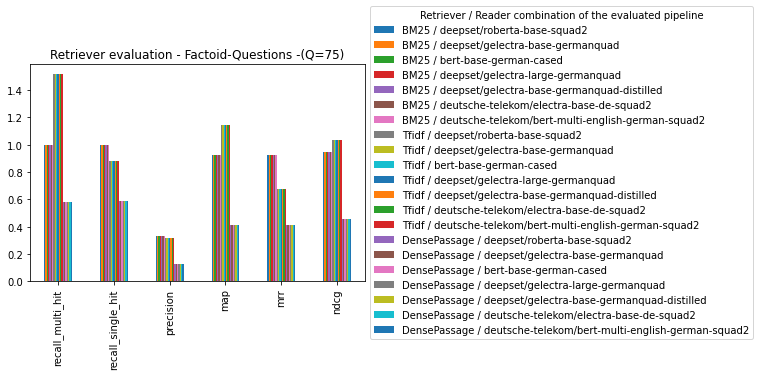

                                                                  exact_match  \
Retriever / Reader                                                              
BM25 / deepset/roberta-base-squad2                                   0.240000   
BM25 / deepset/gelectra-base-germanquad                              0.453333   
BM25 / bert-base-german-cased                                        0.000000   
BM25 / deepset/gelectra-large-germanquad                             0.573333   
BM25 / deepset/gelectra-base-germanquad-distilled                    0.493333   
BM25 / deutsche-telekom/electra-base-de-squad2                       0.493333   
BM25 / deutsche-telekom/bert-multi-english-german-squad2             0.413333   
Tfidf / deepset/roberta-base-squad2                                  0.200000   
Tfidf / deepset/gelectra-base-germanquad                             0.346667   
Tfidf / bert-base-german-cased                                       0.000000   
Tfidf / deepset/gelectra-lar

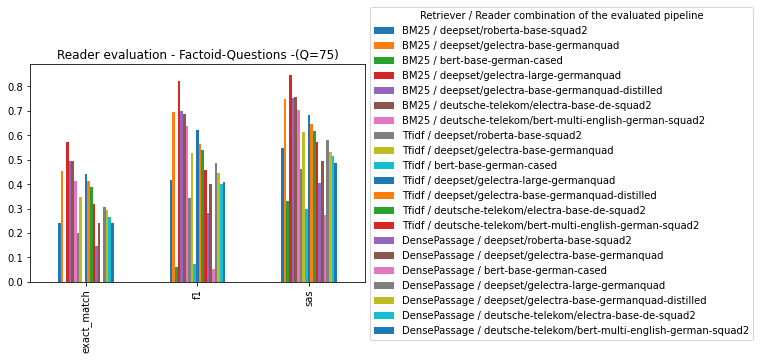

In [ ]:
#Preparation to visualize evaluation results. The evaluation is done in an integrated mode, in other words the output of the reader is the input of the retriever

all_retrievers = list(pipeline_to_metrics.values())
print(f"All retrievers: {all_retrievers}")
reader_eval_values, retriever_eval_values = [], []
ret_columns, read_columns  = [], []

for dic in all_retrievers:
  ret = dic['Retriever']
  read = dic['Reader']

  ret_columns = list(ret.keys())
  read_columns = list(read.keys())

  retriever_eval_values.extend(list(ret.values()))
  reader_eval_values.extend(list(read.values()))



# collect all evaluation results of all retrievers
# a reader has only 6 metrics, therefore values are reshaped for 6 columns
arr = np.array(retriever_eval_values).reshape(-1, 6)
retriever_eval_values = arr.tolist()


# collect all evaluation results of all readers
#reader has only 3 metrics, therefore values reshaped for 3 columns
arr = np.array(reader_eval_values).reshape(-1, 3)
reader_eval_values = arr.tolist()


# get the readers and retrievers used in the pipelines that were evaluated as a list
reader_reatriever_combi = list(pipeline_to_metrics.keys())

#titles for the two plots showing the evaluation
ret_title = f"Retriever evaluation - {dataset_type} -(Q={str(get_nr_questions())})"
read_title = f"Reader evaluation - {dataset_type} -(Q={str(get_nr_questions())})"

#show the plots with the evaluation and save the data in a csv 
show_df(retriever_eval_values, ret_columns, reader_reatriever_combi, ret_title)
show_df(reader_eval_values, read_columns, reader_reatriever_combi, read_title)


# Experiment with Custom Pipeline

The idea of the following cells was to create a custom pipeline that contains two retrievers, BM25 and DPR. As the results are not any better than in the standard pipeline, I didn't discuss this approach in the readme file. The code is left for future reference and ideas.

### Custom Pipeline

In [ ]:
# load reader
reader_GQuad = FARMReader("deepset/gelectra-base-germanquad", top_k=5, return_no_answer=True, use_gpu=True)

# load retriever
retriever_BM25_custom = BM25Retriever(document_store=document_store)
retriever_DPR_custom = DensePassageRetriever(
  document_store=document_store,
  query_embedding_model="deepset/gbert-base-germandpr-question_encoder",
  passage_embedding_model="deepset/gbert-base-germandpr-ctx_encoder"
)

# update document store embeddings, as needed for DPR 
document_store.update_embeddings(retriever_DPR_custom) 


# Create ensembled pipeline
p_ensemble = Pipeline()
p_ensemble.add_node(component=retriever_BM25_custom, name="BM25Retriever", inputs=["Query"])
p_ensemble.add_node(component=retriever_DPR_custom, name="DPRRetriever", inputs=["Query"])
p_ensemble.add_node(
    component=JoinDocuments(join_mode="concatenate"), name="JoinResults", inputs=["BM25Retriever", "DPRRetriever"]
)
p_ensemble.add_node(component=reader_GQuad, name="Reader", inputs=["JoinResults"])


INFO - haystack.modeling.utils -  Using devices: CUDA:0
INFO - haystack.modeling.utils -  Number of GPUs: 1
INFO - haystack.modeling.model.language_model -  LOADING MODEL
INFO - haystack.modeling.model.language_model -  =============
INFO - haystack.modeling.model.language_model -  Could not find deepset/gelectra-base-germanquad locally.
INFO - haystack.modeling.model.language_model -  Looking on Transformers Model Hub (in local cache and online)...
INFO - haystack.modeling.model.language_model -  Automatically detected language from language model name: german
INFO - haystack.modeling.model.language_model -  Loaded deepset/gelectra-base-germanquad
INFO - haystack.modeling.utils -  Using devices: CUDA
INFO - haystack.modeling.utils -  Number of GPUs: 1
INFO - haystack.modeling.infer -  Got ya 2 parallel workers to do inference ...
INFO - haystack.modeling.infer -   0     0  
INFO - haystack.modeling.infer -  /w\   /w\ 
INFO - haystack.modeling.infer -  /'\   / \ 
INFO - haystack.modeli

Updating embeddings:   0%|          | 0/82 [00:00<?, ? Docs/s]

Create embeddings:   0%|          | 0/96 [00:00<?, ? Docs/s]

In [ ]:
# necessary to create png with the structure of the custom pipeline
!apt install libgraphviz-dev graphviz
!pip install pygraphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 62 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-common all 2.24.32-1ubuntu1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-0 amd64 2.24.32-1ubuntu1 [1,769 kB]

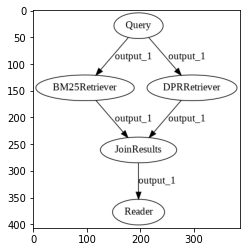

In [ ]:
# show structure of custom pipeline
p_ensemble.draw()
img = mpimg.imread('pipeline.png')
imgplot = plt.imshow(img)
plt.show()

## Evaluation

In [ ]:
eval_labels = document_store.get_all_labels_aggregated(drop_negative_labels=True, drop_no_answers=True)
    #advanced eval results including for reader --> semantic answer similarity (SAS)

eval_result = p_ensemble.eval(labels=eval_labels, sas_model_name_or_path="deepset/gbert-large-sts")
metrics = eval_result.calculate_metrics()

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00, 16.23 Batches/s]


In [ ]:
#prepare needed variables for evaluation
print(metrics)

joinResults = metrics['JoinResults']
reader_pens = metrics['Reader']
print(joinResults)

ret_columns = metrics['Reader'].keys()
ret_val = list(metrics['Reader'].values())
ret_val = np.array(ret_val).reshape(-1, len(ret_columns)).tolist()
print(ret_val)


join_columns = metrics['JoinResults'].keys()
join_val = list(metrics['JoinResults'].values())
join_val = np.array(join_val).reshape(-1, len(join_columns)).tolist()
print(join_val)

reader_reatriever_combi = ["BM25Retriever + DPRRetriever / gelectra-base-germanquad"]
read_title = f"Reader evaluation (Q={str(get_nr_questions())})"
join_title = f"Join evaluation (Q={str(get_nr_questions())})"

{'BM25Retriever': {'recall_multi_hit': 1.0, 'recall_single_hit': 1.0, 'precision': 0.2847460317460318, 'map': 0.926111111111111, 'mrr': 0.9288888888888888, 'ndcg': 0.9461445282805763}, 'DPRRetriever': {'recall_multi_hit': 0.68, 'recall_single_hit': 0.68, 'precision': 0.07733333333333332, 'map': 0.4160476190476191, 'mrr': 0.42488888888888887, 'ndcg': 0.482361541387259}, 'JoinResults': {'recall_multi_hit': 1.0, 'recall_single_hit': 1.0, 'precision': 0.07979347873775118, 'map': 0.49863756613756616, 'mrr': 0.5079393939393939, 'ndcg': 0.6151162920888518}, 'Reader': {'exact_match': 0.4533333333333333, 'f1': 0.6742821884224076, 'sas': 0.7357709}}
{'recall_multi_hit': 1.0, 'recall_single_hit': 1.0, 'precision': 0.07979347873775118, 'map': 0.49863756613756616, 'mrr': 0.5079393939393939, 'ndcg': 0.6151162920888518}
[[0.4533333333333333, 0.6742821884224076, 0.7357708811759949]]
[[1.0, 1.0, 0.07979347873775118, 0.49863756613756616, 0.5079393939393939, 0.6151162920888518]]


In [ ]:
#show and save evaluation of custom pipeline
show_df(ret_val, ret_columns, reader_reatriever_combi, read_title)

show_df(join_val, join_columns, reader_reatriever_combi, join_title)